# TP1 - Détection de points d'intêret

Le but de ce TP est, dans un premier temps, d'implémenter plusieurs méthodes de détections des coins et de déterminer l'influence des différents paramètres qui régissent ces méthodes. Puis, dans un second temps, de travailler sur divers descripteurs en comparant leurs performances.

In [2]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.ndimage as ndi
import scipy.signal as sig
from skimage.io import imread,imshow
from skimage.color import rgb2gray
from skimage.transform import rotate
from matplotlib import patches

import cv2

'\nfrom scipy import signal as sig,ndimage\nimport numpy as np\nfrom skimage.io import imread,imshow\nfrom skimage.color import rgb2gray \n'

In [1]:
from harris import *

## Exercice 1 - Détection de points d'intérêts

Dans cet exercice, nous allons implémenter plusieurs méthodes de détection de points d'intérêt.

### 1 - Détecteur de Harris


### Avec une fenêtre de pondération rectangulaire

L'idée de cette méthode repose sur l'utilisation d'une petite fenêtre rectangulaire que l'on déplace sur l'ensemble de l'image. À chaque itération, ie déplacement de la fenêtre, nous évaluons l'homogénéité globale de l'intensité sur la fenêtre grâce à une matrice M tq :

$$M =
\begin{pmatrix}
\sum I_x^2 & \sum I_xI_y\\
\sum I_xI_y & \sum I_y^2 \\
\end{pmatrix}
=
R^{-1}
\begin{pmatrix}
\lambda_1 & 0\\
0 & \lambda_2 \\
\end{pmatrix}
\qquad(1)$$

L'objectif final est de calculer C, tq :
$$C=det(M)-k*Trace(M)^2 \qquad(2)$$

Ce C permet de comparer les valeurs propres $\lambda$ de la matrice M sans avoir besoin de les calculer. 

Solution adoptée :
Nous commencons par afficher l'image en noire et blanc afin de travailler sur les intensités des pixels. Puis, nous calculons les dérivées en x et en y de l'intensité de chaque pixel de l'image. Pour cela nous utilisons le filtre de Sobel. Nous convoluons le filtre à notre image :
$$
I_x =
\begin{pmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1 
\end{pmatrix}
* 
Image \\
$$
$$
I_y =
\begin{pmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1 
\end{pmatrix}
* 
Image
$$

Ensuite, nous calculons les coefficients $I_x^2$, $I_y^2$ et $I_xI_y$ qui sont nécessaires afin d'obtenir la matrice $M$. 

Enfin, nous parcourons l'ensemble de l'image avec une fenêtre (pour l'instant nous avons choisi une taille $3p*3p$) par pas de 1 pixel. À chaque itération, nous calculons les 4 coefficients de la matrice $M$. Puis nous déterminons $C$ à l'aide de l'équation $2$ après avoir calculé le déterminant et la trace de $M$. Pour l'instant, nous choisissons $k=0,04$ (nous étudierons son influence par la suite). 
Pour identifier les points d'intérêt, nous testons $C$. Si $C>5$ (pour $C>0$, il y a beaucoup trop de points d'intérêt), nous marquons le pixel en rouge sur l'image. Voici l'image que nous obtenons :

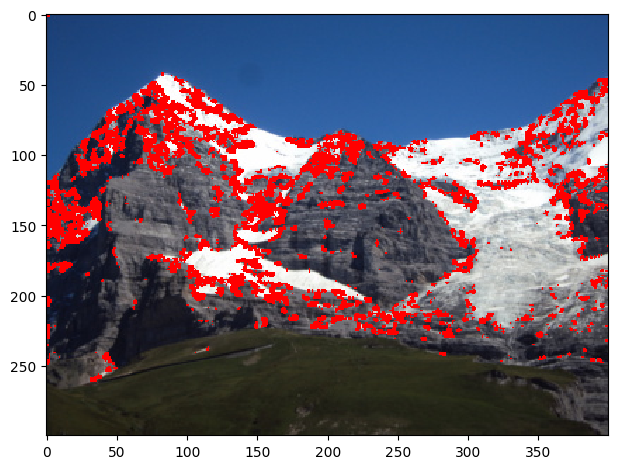

In [2]:
img = "M1.JPG"

coins_brute,count_rect = detection_harris_rectangle(img,0)
imshow(coins_brute)


### Commentaire :

On remarque sur la figure ci-dessus la présence d'amas : il y a un regroupement de pixel rouge au niveau de chaque point d'intérêt là où nous voudrions un seul point. Nous allons donc procéder par la suite à la suppressions des non maxima locaux pour parer à ce problème. Nous constatons également que les points d'intérêt tels que le sommet de la montagne ne sont pas marqués en rouge. Cela est dû au fait que notre fenêtre de pondération est trop petite et qu'elle détecte un contour au lieu d'un coin. Nous modulerons la taille de la fenêtre par la suite pour vérifier cette alégation.

### Fonction pour la suppression des non-maxima locaux

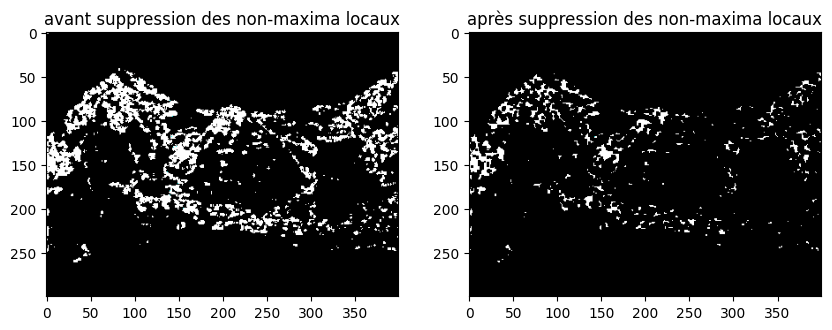

In [3]:
img_path = "M1.JPG"

img = imread(img_path)

img_suppr,c_supr_rect= sup_non_maxima_optimized(coins_brute,img_path)

### Affichage de la différence avec/sans maxima locaux

img_suppr = img - img_suppr
img_suppr[img_suppr < 0] = 0
img_suppr[img_suppr > 0] = 255

coins_brute = img - coins_brute
coins_brute[coins_brute < 0] = 0
coins_brute[coins_brute > 0] = 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(coins_brute, cmap='gray')
ax1.set_title('avant suppression des non-maxima locaux')
ax2.imshow(img_suppr, cmap='gray')
ax2.set_title('après suppression des non-maxima locaux')
plt.show()

### Commentaire :

Nou observons une nette diminution des amas de points, ce qui signifie que la fonction de suppression des non maxima à eu un impact. En revanche cette diminution n'est pas totale, il reste encore des amas de points.

### Avec une fenêtre de pondération gaussienne

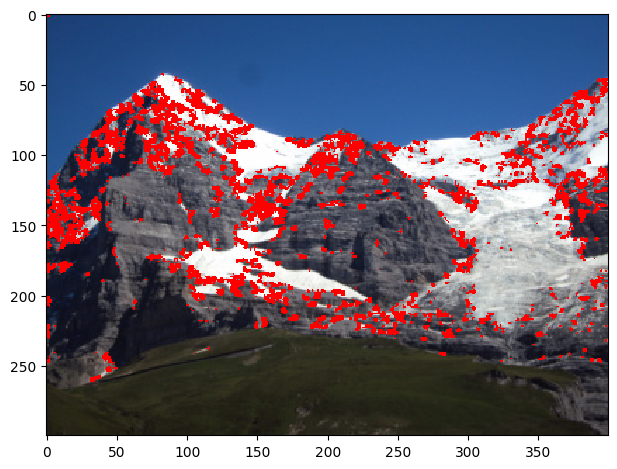

In [9]:
img_path = "M1.JPG"
coins_brute_gauss,count_gauss= detection_harris_gauss_optimized(img_path,0)
imshow(coins_brute_gauss)

### Commentaire :

Le détecteur de Harris avec fenêtre gaussienne pondère les gradients d'intensité locaux en fonction de la distance par rapport au centre de la fenêtre. ie, il utilise une fenêtre gaussienne pour calculer la matrice de Harris, ce qui implique que les gradients sont lissés et que les variations locales sont atténuées.
En conséquence, il détecte principalement des coins et des bords où les variations d'intensité sont significatives et où les gradients sont forts. Il est moins sensible aux variations locales. On observe en effet moins d'amas de points qu'avec la fenêtre rectangulaire.

### Avec suppression :

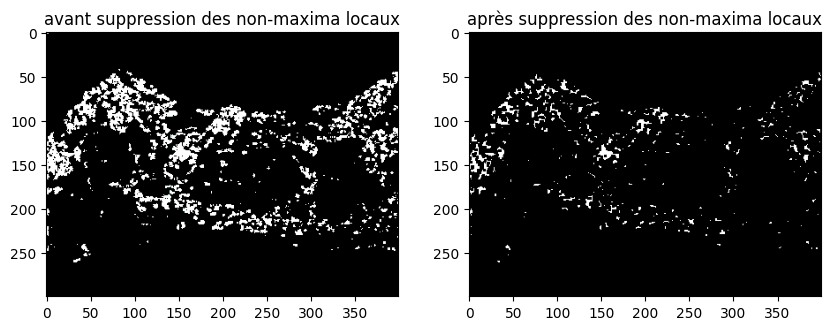

In [10]:
img_path = "M1.JPG"

img = imread(img_path)

img_suppr_gauss,c_supr_gauss = sup_non_maxima_optimized(coins_brute_gauss,img_path)

### Affichage de la différence avec/sans maxima locaux

img_suppr_gauss = img - img_suppr_gauss
img_suppr_gauss[img_suppr_gauss < 0] = 0
img_suppr_gauss[img_suppr_gauss > 0] = 255

coins_brute_gauss = img - coins_brute_gauss
coins_brute_gauss[coins_brute_gauss < 0] = 0
coins_brute_gauss[coins_brute_gauss > 0] = 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(coins_brute_gauss, cmap='gray')
ax1.set_title('avant suppression des non-maxima locaux')
ax2.imshow(img_suppr_gauss, cmap='gray')
ax2.set_title('après suppression des non-maxima locaux')
plt.show()

### Commentaire :

Même commentaire que pour la fenêtre rectangulaire : il y a moins d'amas mais il en reste quand même.


### Avec une matrice hessienne :

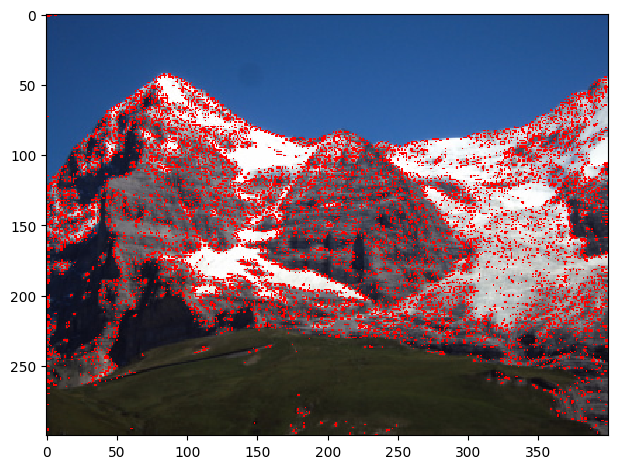

In [11]:
img_path = "M1.JPG"

coins_brute_hess,count_hess = detection_hessienne(img_path,0)
imshow(coins_brute_hess)

### Commentaire :

La hessienne se base sur les dérivées secondes de l'intensité des pixels. Elle est plus sensible aux variations et peut détecter un éventail plus large de points d'intérêt, y compris des points plats où les variations d'intensité sont faible. Ceci est visible sur la figure ci-dessus. En effet, on constate que les amas de points d'intérêt sont beaucoup plus petits que pour le détecteur de Harris et couvrent une plus grandes surface de l'image. Le détecteur peut distinguer des points d'intérêt dans des zones où les variations d'intensité sont subtiles.

### Avec suppression :

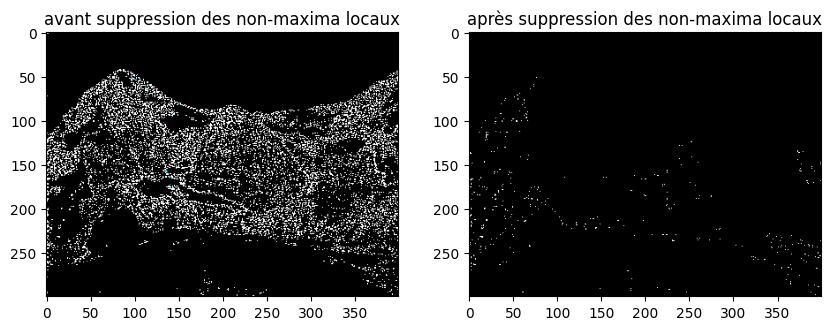

In [8]:
img_path = "M1.JPG"

img = imread(img_path)
coins_brute_hess,count_hess = detection_hessienne(img_path,0)
img_suppr_hess,c_supr_hess = sup_non_maxima_optimized(coins_brute_hess, img_path)

### Affichage de la différence avec/sans maxima locaux

img_suppr_hess = img - img_suppr_hess
img_suppr_hess[img_suppr_hess < 0] = 0
img_suppr_hess[img_suppr_hess > 0] = 255

coins_brute_hess = img - coins_brute_hess
coins_brute_hess[coins_brute_hess < 0] = 0
coins_brute_hess[coins_brute_hess > 0] = 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(coins_brute_hess, cmap='gray')
ax1.set_title('avant suppression des non-maxima locaux')
ax2.imshow(img_suppr_hess, cmap='gray')
ax2.set_title('après suppression des non-maxima locaux')
plt.show()

### Commentaire :

On constate cette fois que la suppression des non-maxima à retirer une grande partie des points d'intérêt détectés par la Hessienne. Comment expliquer cela ? Comme nous l'expliquions précédemment, la Hessienne détecte des points d'intérêt dans des zones où les variations d'intensité sont "subtiles" c'est-à-dire faible. Or, la fonction de suppression des non-maxima locaux élimine tous les points d'intérêt dont les plus proches voisins sont semblables en terme d'intensité. Or c'est le cas pour une grande partie des points détectés par la hessienne.

### Influence du type de fenêtre de pondération, de sa taille ainsi que du paramètre k dans la détection de point d’intérêt.

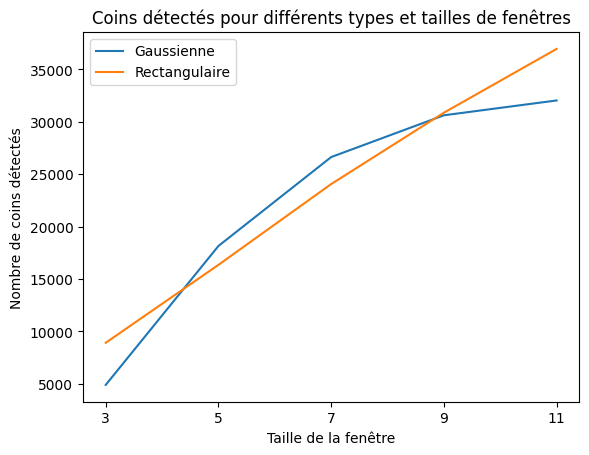

In [65]:
# Définition d'un ensemble de types et de tailles de fenêtres à tester
types_fenetre = ['gaussian', 'uniform', 'hess']
tailles_fenetre = [3, 5, 7, 9, 11]

# Initialisation d'une liste pour stocker le nombre de coins détectés pour chaque type et taille de fenêtre
num_corners_gaussian = []
num_corners_uniform = []
#num_corners_hess = []

# Boucle sur tous les types et tailles de fenêtres
for window_type in types_fenetre:
    if window_type == 'gaussian':
        func = detection_harris_gauss_optimized
        num_corners = num_corners_gaussian
    #elif window_type == 'hess':
    #    func = detection_hessienne
    #    num_corners = num_corners_hess
    else:
        func = detection_harris_rectangle
        num_corners = num_corners_uniform
    for window_size in tailles_fenetre:
        # Exécution de l'algorithme de détection de coins avec le type et la taille de fenêtre actuels
        img_corners, num_detected = func(img, 0, window_size)
        # Stockage du nombre de coins détectés
        num_corners.append(num_detected)

# Tracé du nombre de coins détectés en fonction du type et de la taille de fenêtre
fig, ax1 = plt.subplots()
ax1.plot(num_corners_gaussian, label='Gaussienne')
ax1.plot(num_corners_uniform, label='Rectangulaire')
#ax1.plot(num_corners_hess, label='Hessienne')
ax1.set_xticks(range(len(tailles_fenetre)))
ax1.set_xticklabels(tailles_fenetre)
ax1.set_xlabel('Taille de la fenêtre')
ax1.set_ylabel('Nombre de coins détectés')
ax1.set_title('Coins détectés pour différents types et tailles de fenêtres')
ax1.legend()

plt.show()

### Commentaire :
On constate que globalement, pour tous les types de fenêtre, le nombre de coins détectés augmente avec la taille de la fenêtre. 
Comment expliquer cela ?
Il semble que cette variation dépende du type d'image que l'on traite. En effet, ici nous avons affaire à une image de montagne. Ainsi, les coins principaux qui sont les arrêtes de la montagnes sont relativement gros et donc plus facilement détectables avec de grandes fenêtres. Si on réalise le même test avec une autre image ou les coins sont plus petits, nous ne devrions pas avoir le même type de variation

#### 1) Influence du paramètre k

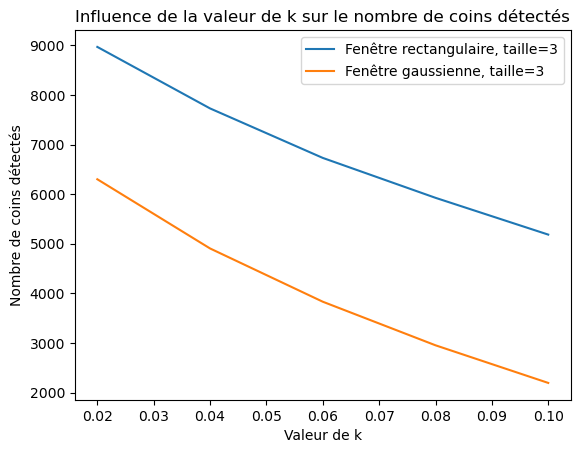

In [151]:
# Différentes valeurs de k à tester
k_values = [0.02, 0.04, 0.06, 0.08, 0.1]

num_corners_rectangular = []
num_corners_gaussian = []

# Boucle sur chaque valeur de k
for k in k_values:
    # Détection des coins avec une fenêtre rectangulaire pour les différents k
    img_corners, num_detected = detection_harris_rectangle(img, 0, 3, k)
    num_corners_rectangular.append(num_detected)
    # Détection des coins avec une fenêtre gaussienne cette fois
    img_corners, num_detected = detection_harris_gauss_optimized(img, 0, 3, k)
    num_corners_gaussian.append(num_detected)

# Tracé du nombre de coins détectés pour chaque type de fenêtre en fonction de la valeur de k
plt.plot(k_values, num_corners_rectangular, label='Fenêtre rectangulaire, taille=3')
plt.plot(k_values, num_corners_gaussian, label='Fenêtre gaussienne, taille=3')
plt.legend()
plt.xlabel('Valeur de k')
plt.ylabel('Nombre de coins détectés')
plt.title('Influence de la valeur de k sur le nombre de coins détectés')
plt.show()


### Commentaire :

Le résultat est cohérent. En effet, le paramètre k détermine la sélectivité de notre détecteur. Ainsi, plus k est grand et plus le détecteur est sélectif et donc moins il détect de points d'intérêt.

### Rotation de l'image

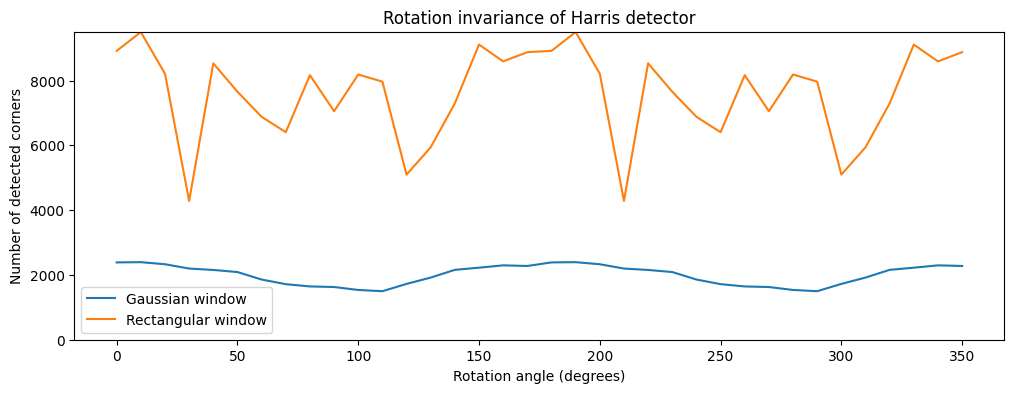

In [66]:

# Define the rotation angles to test
angles = np.arange(0, 360, 20)

# Initialize a list to store the number of detected corners for each angle
num_corners_gauss = []
num_corners_rect = []
#num_corners_hess = []

# Apply the Harris detector for each angle and store the number of detected corners
for angle in angles:
    _, num_detected_gauss = detection_harris_gauss_optimized(img, angle,sigma=2)
    num_corners_gauss.append(num_detected_gauss)
    _, num_detected_rect = detection_harris_rectangle(img, angle)
    num_corners_rect.append(num_detected_rect)
    #_, num_detected_hess = detection_harris_hessienne(img, angle)
    #num_corners_hess.append(num_detected_hess)

# Plot the number of detected corners as a function of the rotation angle
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(angles, num_corners_gauss, label='Gaussian window')
ax.plot(angles, num_corners_rect, label='Rectangular window')
#ax.plot(angles, num_corners_hess, label='Hessian')
ax.set_xlabel('Rotation angle (degrees)')
ax.set_ylabel('Number of detected corners')
ax.set_title('Rotation invariance of Harris detector')
ax.legend()

max_value = max(max(num_corners_gauss), max(num_corners_rect), max(num_corners_hess))
ax.set_ylim([0, max_value + 10])

plt.show()


### Commentaire :

Comme nous pouvions nous y attendre, nous observons que le détecteur de Harris est invariant par rotation avec l'utilisation d'une fenêtre Gaussienne. En revanche, ce n'est pas du tout le cas avec la fenêtre rectangulaire dont le nombre de points d'intérêt détectés varie fortement avec l'angle de rotation.

Pourquoi cela ?

Avec la fenêtre gaussienne, les gradients d'intensité dans toutes les directions sont pris en compte de manière égale. La fenêtre gaussienne étale les variations d'intensité dans toutes les directions ce qui entraîne une invariance par rotation de la détection. Mais pour la fenêtre rectangulaire, aucune pondération n'est effectuée selon la direction, ie lorsque l'image est tournée, les gradients d'intensité changent.

## 2 - Détecteur FAST

In [2]:
from fast import *

## Méthode 1 - méthode itérative

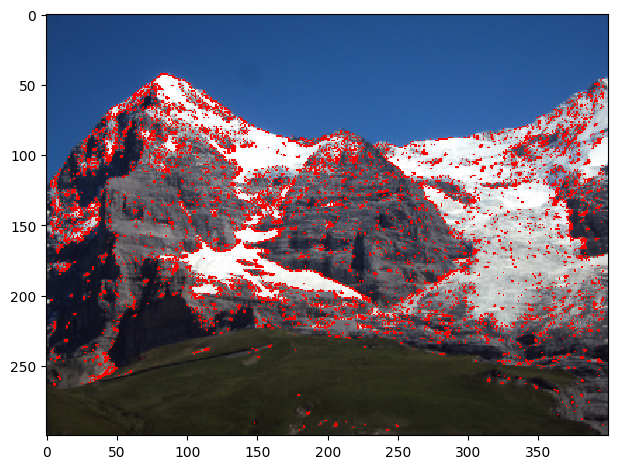

In [9]:
''' TEST de la méthode FAST '''

img_FAST, _ = fast_1("M1.JPG", 0.05, 12, 0)

imshow(img_FAST)

### Commentaire :

Nous pouvons observer avec la méthode FAST que les points d'intérêt sont moins "amassés" qu'avec la méthode de Harris. De plus, il sont étalés géographiquement, ie FAST détecte des points dans plus de zones (un peu comme avec la hessienne mais en moindre proportions). La méthode FAST semble donc plus sélective et plus efficace. Nous vérifierons cela dans la quetion 3.

## Suppression des non-maxima locaux pour FAST

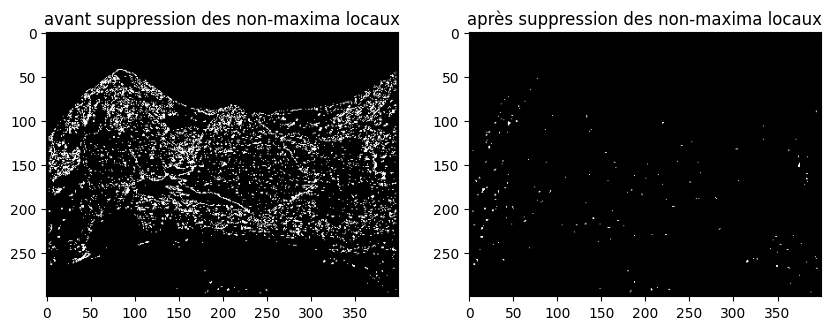

In [11]:

image = imread("M1.JPG")

img_FAST, _ = fast_1("M1.JPG", 0.05, 12, 0)
new_FAST_image,c = sup_non_maxima_optimized(img_FAST, "M1.JPG")


### Affichage de la différence avec/sans maxima locaux

new_FAST_image = image - new_FAST_image
new_FAST_image[new_FAST_image < 0] = 0
new_FAST_image[new_FAST_image > 0] = 255

img_FAST = image - img_FAST
img_FAST[img_FAST < 0] = 0
img_FAST[img_FAST > 0] = 255

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img_FAST, cmap='gray')
ax1.set_title('avant suppression des non-maxima locaux')
ax2.imshow(new_FAST_image, cmap='gray')
ax2.set_title('après suppression des non-maxima locaux')
plt.show()


## FAST : Rotation de l'image

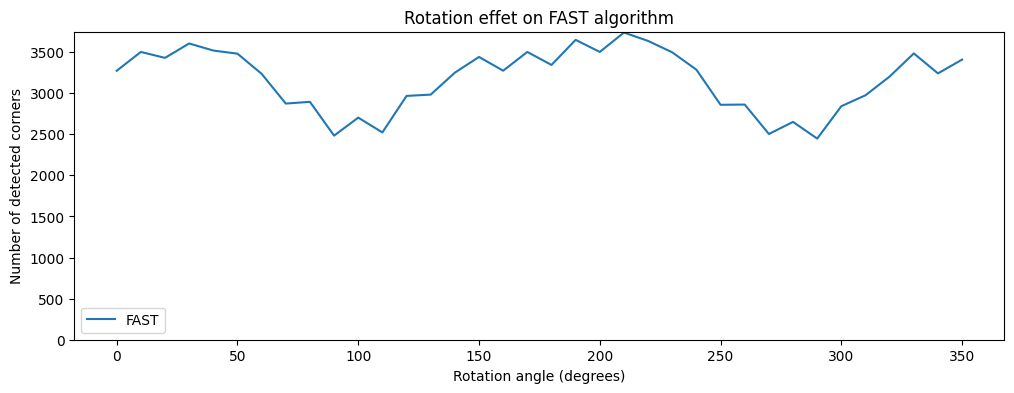

Le nombre max de détection est : 3737 ; le nombre min de détection est : 2447


In [74]:
# Définition des angles de rotation à tester
angles = np.arange(0, 360, 10)

# Initialiser une liste pour stocker le nombre de coins détectés pour chaque angle
num_corners_fast = []

# Appliquer le détecteur FAST pour chaque angle et enregistrer le nombre de coins détectés.
for angle in angles:
    _, num_detected_fast = fast_1(img, 0.1, 12, angle)
    num_corners_fast.append(num_detected_fast)

# Tracer le nombre de coins détectés en fonction de l'angle de rotation
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(angles, num_corners_fast, label='FAST')
ax.set_xlabel('Rotation angle (degrees)')
ax.set_ylabel('Number of detected corners')
ax.set_title('Rotation effet on FAST algorithm')
ax.legend()

max_value = max(num_corners_fast)
min_value = min(num_corners_fast)

ax.set_ylim([0, max_value + 10])

plt.show()

print("Le nombre max de détection est :", max_value, "; le nombre min de détection est :", min_value)

### Commentaire :

Nous pouvons constater que le détecteur FAST n'est pas invariant par rotation. Le nombre de détection s'étend de 2447 pour le minimum à 3737 pour le maximum. Il y a donc 1290 détections de différence.

FAST n'est pas invariant par rotation car c'est une méthode qui repose sur des comparaisons locales d'intensité des pixels. 

La méthode FAST ne prend pas en compte l'orientation des points d'intérêt. Si on fait tourner l'image, les variations locales de l'intensité qui étaient significatives avant la rotation peuvent ne plus l'être après la rotation. De plus, FAST repose sur une disposition spécifique des pixels dans le cercle de test. Lorsque l'image est tournée, cette disposition peut changer, affectant ainsi les comparaisons locales.



## 3 - Comparaison FAST/Harris

In [3]:
from comparaison import *

### Comparaison des points d'intérêt

Pour réaliser cette comparaison, nous proposons deux méthodes :
* Tout d'abord, nous réaliserons une simple soustraction entre les deux images afin d'afficher uniquement les point d'intérêt qui ne sont pas communs aux deux détections.
* Puis, nous comparerons le quotient du nombre de points d'intérêt post suppression des non-maxima locaux sur le nombre de points d'intérêt total, ce qui devrait nous donner un indice intéressant sur la précision des méthodes (plus le quotient est proche de 1, plus la méthode est précise, plus il est proche de 0, le moins elle l'est). 

### Méthode 1 

Nombre de points d'intérêts uniques à chaque méthode : 12586


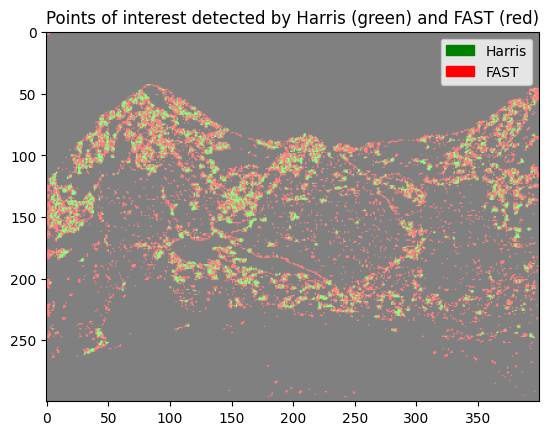

In [4]:

img_points = comp_soustraction( "M1.JPG" )

# Affichage des points d'intérêts uniques à chaque méthode
fig, ax = plt.subplots()
#ax.imshow(img)
ax.imshow(img_points, alpha=0.5)
ax.set_title('Points of interest detected by Harris (green) and FAST (red)')
ax.legend(handles=[patches.Patch(color='green', label='Harris'), patches.Patch(color='red', label='FAST')])
plt.show()


### Commentaire :

On constate que les points spécifiques à FAST sont plus étalés géographiquement. La méthode FAST détecte les crêtes de la montagnes avec plus de précision. On peut s'avancer à dire que FAST détecte plus de points d'intérêt que Harris. Globalement les seuls endroits où Harris détecte des points que FAST n'a pas détecté sont les non-maxima locaux, ie des petites zones où Harris détecte une grande quantité de points d'intérêt.

### Méthode 2

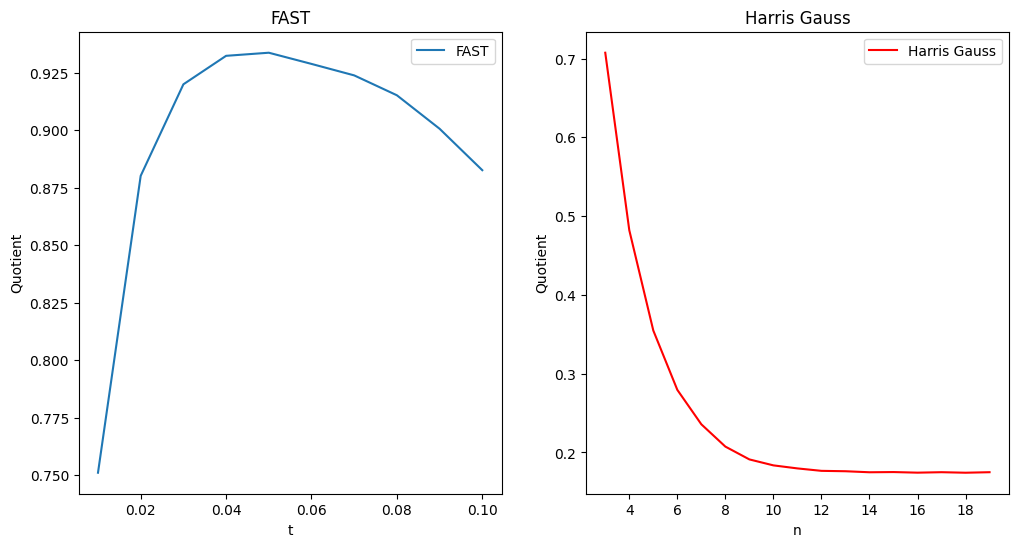

In [5]:

quotient_FAST, quotient_Harris_Gauss, k_fast_values, n_harris_values = comp_quotient("M1.JPG")

# Plot the results as two curves side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Plot the FAST curve on the first subplot
ax1.plot(k_fast_values, quotient_FAST, label='FAST')
ax1.set_xlabel('t')
ax1.set_ylabel('Quotient')
ax1.set_title('FAST')
ax1.legend()

# Plot the Harris Gauss curve on the second subplot
ax2.plot(n_harris_values, quotient_Harris_Gauss, label='Harris Gauss', color='red')
ax2.set_xlabel('n')
ax2.set_ylabel('Quotient')
ax2.set_title('Harris Gauss')
ax2.legend()

plt.show()

### Commentaire :

On observe que pour la méthode FAST (avec n fixé à 12), le quotient est globalement assez proche de 1, ce qui signifie que peu de points d'intérêt sont éliminés, ce qui implique que la méthode est précise dans sa sélection des points d'intérêt. La croissance du quotient pour les premières valeurs de t est dûe au fait que pour des petites valeurs de t, FAST est moins sélective puisque l'intervalle de sélection est plus large. Ainsi, il y aura plus de points d'intérêt sélectionnés et donc plus de non-maxima locaux.

En revanche, pour Harris (avec k fixé à 0.04), on constate que le quotient est assez faible, ce qui signifie que beaucoup de points ont été supprimés par la fonction de suppression des non-maxima locaux. Ainsi, la fonction Harris est beaucoup moins sélective. Pour 1 "vrai" point d'intérêt, elle en détecte une multitude. D'ailleurs, cela se voit visuellement sur l'image où l'on affiche les points d'intérêt en rouge. On observe sur cette image beaucoup de conglomérats de points, beaucoup plus que sur l'image résultante du traitement par FAST. La décroissance du quotient avec l'augmentation de n est dûe au fait que, avec n croissant, il y a beaucoup plus de point d'intérêt détectés (comme nous avons pu l'observer précédemment) et une plus grande partie de ces points sont des non maxima locaux. 

## Comparaison aux méthodes déjà implémentées

### Comparaison en terme de vitesse d'exécution

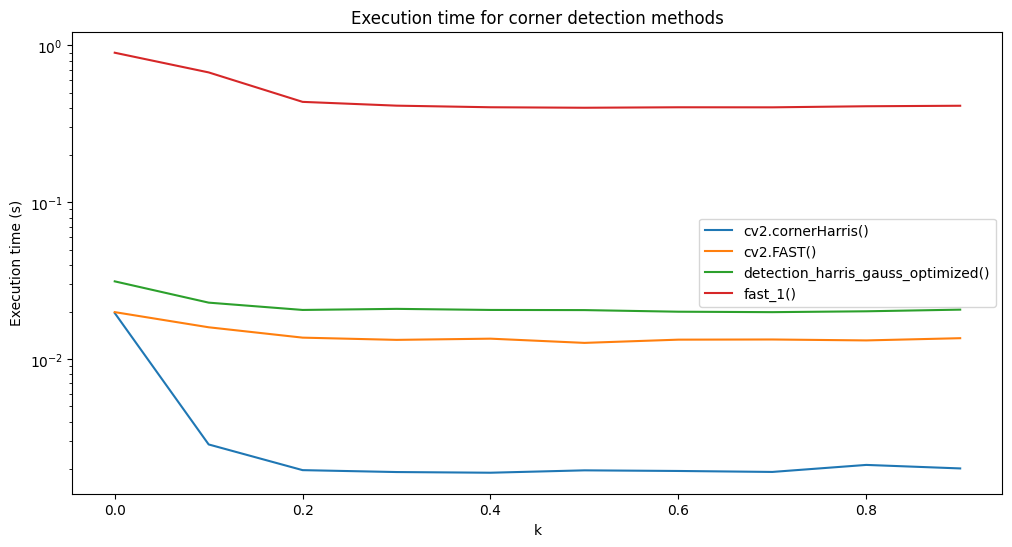

In [6]:
time_cv2_Harris, time_cv2_FAST, time_Harris_Gauss, time_FAST, k_values = comp_openCV("M1.JPG")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(k_values, time_cv2_Harris, label='cv2.cornerHarris()')
ax.plot(k_values, time_cv2_FAST, label='cv2.FAST()')
ax.plot(k_values, time_Harris_Gauss, label='detection_harris_gauss_optimized()')
ax.plot(k_values, time_FAST, label='fast_1()')
ax.set_xlabel('k')
ax.set_ylabel('Execution time (s)')
ax.set_title('Execution time for corner detection methods')
ax.legend()
ax.set_yscale('log')
plt.show()

### Commentaire :

Comme nous pouvions nous en douter, les fonctions d'open cv sont beaucoup plus performante que les notres, d'environ un facteur 10 (voir plus pour FAST).

# Exercice 2 : Description et matching des points d'intérêt

In [17]:
from Matching import *

In [ ]:

A,B = bloc_descriptor2("M1.JPG", "M2.JPG", 7,0.1)
C,D = bloc_descriptor2("M2.JPG", "M3.JPG", 7,0.1)

In [ ]:

# Load the image
img1 = imread("M1.JPG")

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the image
ax.imshow(img1)

# Select 100 random points from A
sumx=0
sumy=0
sumx2=0
sumy2=0
# Loop over the selected points and plot the arrows
for i in range(len(A)):
    x1, y1 = A[i]
    x2, y2 = B[i]
    sumx+=x2-x1
    sumy+=y2-y1
    ax.arrow(y1, x1, y2-y1, x2-x1, color='r', head_width=4, head_length=7)

for i in range(len(C)):
    x1, y1 = C[i]
    x2, y2 = D[i]
    sumx2+=x2-x1
    sumy2+=y2-y1

meanx=sumx/len(A)
meany=sumy/len(A)
meanx2=sumx2/len(C)
meany2=sumy2/len(C)


# Show the plot
plt.show()
print(meanx,meany)
print(meanx2,meany2)


In [18]:
# Load the images
M1 = imread('M1.JPG')
M2 = imread('M2.JPG')
M3 = imread('M3.JPG')


# Create a new image by concatenating the two images horizontally
panorama1 = np.concatenate((M1[0:int((300-np.floor(meanx))),0:int((400+np.floor(-meany)))], M2[(int(np.floor(meanx))):300,(int(-np.floor(-meany))):400]), axis=1)
panorama2 = np.concatenate((M2[0:int((300-np.floor(meanx2))),0:int((400+np.floor(meany2)))], M3[(int(np.floor(meanx2))):300,(int(-np.floor(meany2))):400]), axis=1)

# Concatenate the two panoramas horizontally to create a new panorama

# Display the panorama
plt.imshow(panorama2)
plt.show()

# References

